# AutoEncoder with Convolution

- 발표자: 통합과정 최찬혁

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from torchsummary import summary as summary_
import matplotlib.pyplot as plt
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [3]:
EPOCH = 30
BATCH_SIZE = 64
NUM_WORKERS = 4
learning_rate = 5e-3

In [7]:
# Fashion MNIST 데이터셋 불러오기
trainset = datasets.FashionMNIST(
    root      = './Data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)

testset = datasets.FashionMNIST(
    root      = './Data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = NUM_WORKERS
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    num_workers = NUM_WORKERS
)

## Convolutional AutoEncoder

- If we use MaxPool2d, we might lose the location-information of input images.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential( # nn.Sequential을 사용해 encoder와 decoder 두 모듈로 묶어줍니다.
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Linear(64, latent_dim)

        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64*3*3),
            nn.ReLU(),
            nn.Unflatten(1,(32,7,7)),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2),
            nn.Sigmoid()       # 픽셀당 0과 1 사이로 값을 출력하는 sigmoid()함수를 추가합니다.
        )

    def forward(self, x):
        encoded = self.encoder(x) # encoder는 encoded라는 latent vector를 만들고
        decoded = self.decoder(encoded) # decoder를 통해 decoded라는 복원이미지를 만듭니다.
        return encoded, decoded

In [6]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate) 
criterion = nn.MSELoss()

In [7]:
summary_(autoencoder.encoder, (1,28,28), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 16, 28, 28]             160
              ReLU-2           [64, 16, 28, 28]               0
         MaxPool2d-3           [64, 16, 14, 14]               0
            Conv2d-4           [64, 32, 14, 14]           4,640
              ReLU-5           [64, 32, 14, 14]               0
         MaxPool2d-6             [64, 32, 7, 7]               0
           Flatten-7                 [64, 1568]               0
            Linear-8                   [64, 64]         100,416
              ReLU-9                   [64, 64]               0
           Linear-10                    [64, 3]             195
Total params: 105,411
Trainable params: 105,411
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 21.50
Params size (MB): 0.40
Estimated 

In [8]:
summary_(autoencoder.decoder, (3,), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [64, 64]             256
              ReLU-2                   [64, 64]               0
            Linear-3                 [64, 1568]         101,920
              ReLU-4                 [64, 1568]               0
         Unflatten-5             [64, 32, 7, 7]               0
   ConvTranspose2d-6           [64, 16, 14, 14]           2,064
              ReLU-7           [64, 16, 14, 14]               0
   ConvTranspose2d-8            [64, 1, 28, 28]              65
           Sigmoid-9            [64, 1, 28, 28]               0
Total params: 104,305
Trainable params: 104,305
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 6.19
Params size (MB): 0.40
Estimated Total Size (MB): 6.59
-------------------------------------------

In [9]:
# 원본 이미지를 시각화 하기
view_data = testset.data[:10].view(-1, 1, 28, 28)
view_data = view_data.type(torch.FloatTensor)/255.
#픽셀의 색상값이 0~255이므로 모델이 인식하는 0부터 1사이의 값으로 만들기 위해 255로 나눠줍니다.

In [10]:
# 학습하기 위한 함수
def train(autoencoder, train_loader):
    autoencoder.train()
    total_loss=0
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 1, 28, 28).to(DEVICE)
        y = x.view(-1, 1, 28, 28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        total_loss = total_loss + loss
        optimizer.zero_grad() #기울기에 대한 정보를 초기화합니다.
        loss.backward() # 기울기를 구합니다.
        optimizer.step() #최적화를 진행합니다.

    total_loss = total_loss.item()
    print("total train loss:" + str(total_loss))
    
    return total_loss

In [11]:
def test(autoencoder, test_loader):
    autoencoder.eval()
    total_loss=0
    for step, (x, label) in enumerate(test_loader):
        x = x.view(-1, 1, 28, 28).to(DEVICE)
        y = x.view(-1, 1, 28, 28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        total_loss = total_loss + loss


    total_loss = total_loss.item()
    print("total test loss:" + str(total_loss))
    
    return total_loss

total train loss:30.00181770324707
total test loss:4.050273895263672
[Epoch 1]


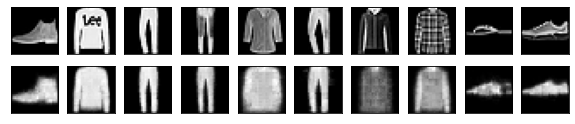

total train loss:23.640377044677734
total test loss:3.8916409015655518
[Epoch 2]


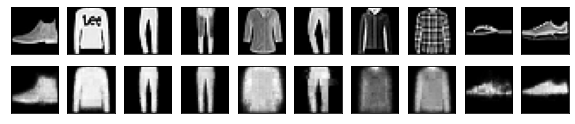

total train loss:22.697786331176758
total test loss:3.779968023300171
[Epoch 3]


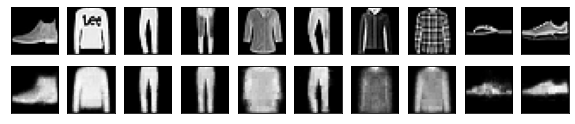

total train loss:22.180055618286133
total test loss:3.714221239089966
[Epoch 4]


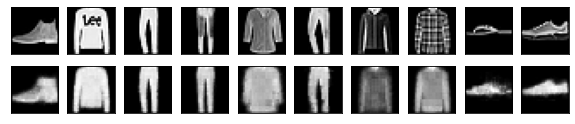

total train loss:21.910444259643555
total test loss:3.685023784637451
[Epoch 5]


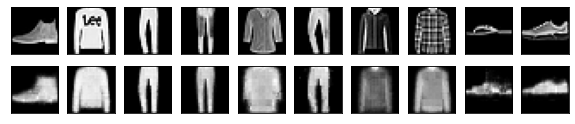

total train loss:21.660612106323242
total test loss:3.6210777759552
[Epoch 6]


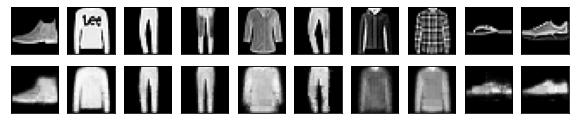

total train loss:21.50041389465332
total test loss:3.602559804916382
[Epoch 7]


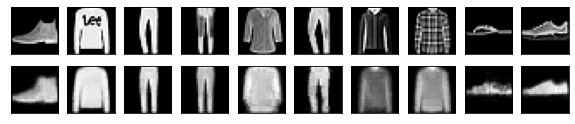

total train loss:21.35469627380371
total test loss:3.581491708755493
[Epoch 8]


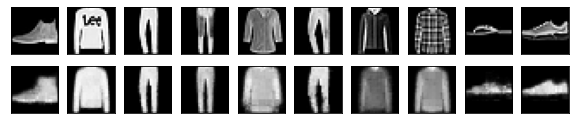

total train loss:21.230310440063477
total test loss:3.5678555965423584
[Epoch 9]


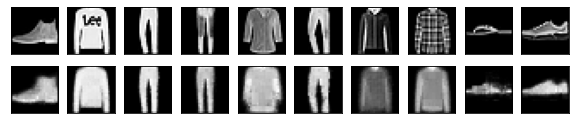

total train loss:21.121135711669922
total test loss:3.5716207027435303
[Epoch 10]


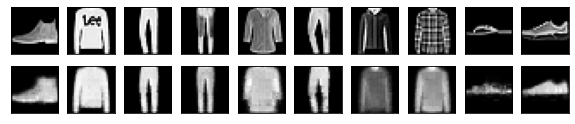

total train loss:21.0245418548584
total test loss:3.5358362197875977
[Epoch 11]


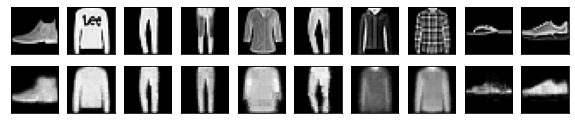

total train loss:20.92878532409668
total test loss:3.5368852615356445
[Epoch 12]


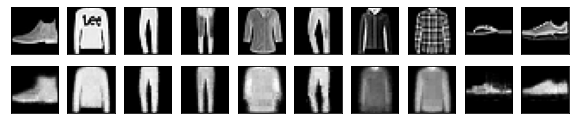

total train loss:20.831357955932617
total test loss:3.5436105728149414
[Epoch 13]


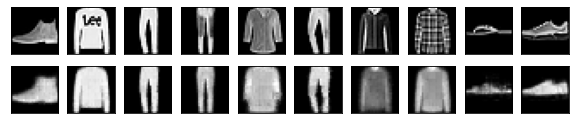

total train loss:20.79991912841797
total test loss:3.531146764755249
[Epoch 14]


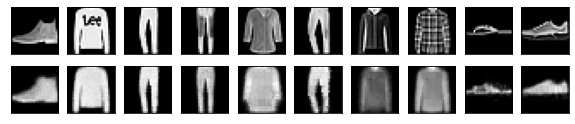

total train loss:20.73055076599121
total test loss:3.5106208324432373
[Epoch 15]


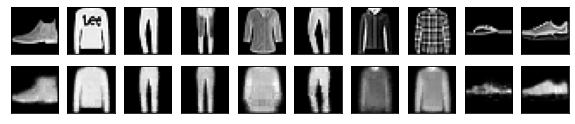

total train loss:20.68090057373047
total test loss:3.4996261596679688
[Epoch 16]


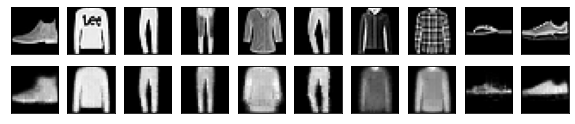

total train loss:20.62672233581543
total test loss:3.499016761779785
[Epoch 17]


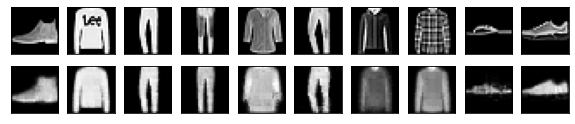

total train loss:20.575538635253906
total test loss:3.4861059188842773
[Epoch 18]


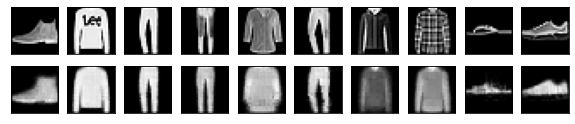

total train loss:20.5534610748291
total test loss:3.5112791061401367
[Epoch 19]


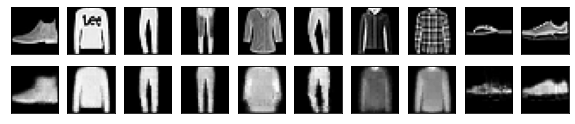

total train loss:20.51007843017578
total test loss:3.491431951522827
[Epoch 20]


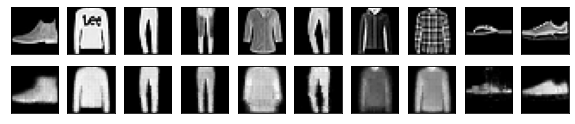

total train loss:20.48473358154297
total test loss:3.4745147228240967
[Epoch 21]


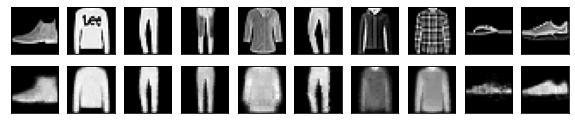

total train loss:20.452272415161133
total test loss:3.475983142852783
[Epoch 22]


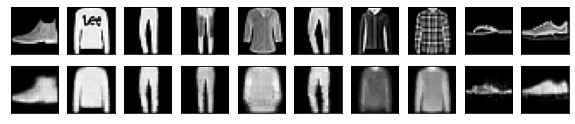

total train loss:20.43413734436035
total test loss:3.4643335342407227
[Epoch 23]


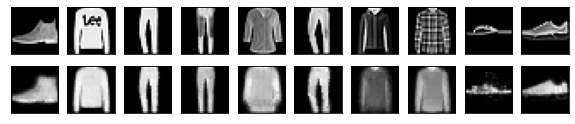

total train loss:20.38901138305664
total test loss:3.474400043487549
[Epoch 24]


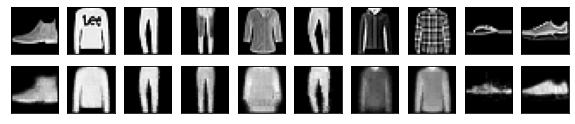

total train loss:20.36488914489746
total test loss:3.461047649383545
[Epoch 25]


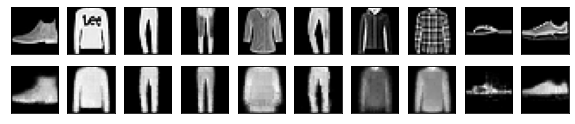

total train loss:20.37539291381836
total test loss:3.4845988750457764
[Epoch 26]


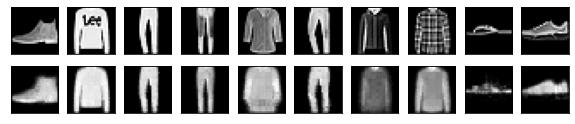

total train loss:20.304431915283203
total test loss:3.4661664962768555
[Epoch 27]


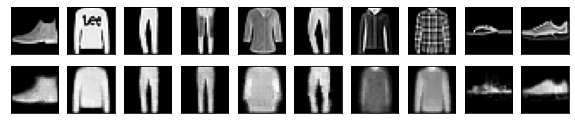

total train loss:20.30685043334961
total test loss:3.453667640686035
[Epoch 28]


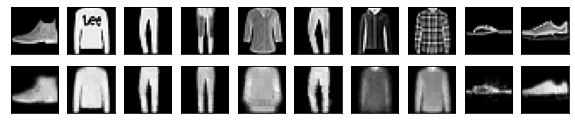

total train loss:20.305158615112305
total test loss:3.4438719749450684
[Epoch 29]


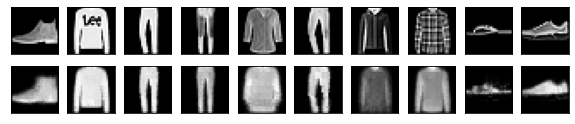

total train loss:20.254018783569336
total test loss:3.44858455657959
[Epoch 30]


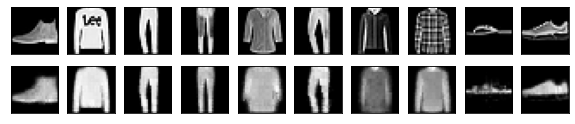

In [12]:
train_losses=[]
test_losses=[]
#학습하기
for epoch in range(1, EPOCH+1):
    loss_epoch = train(autoencoder, train_loader)
    train_losses.append(loss_epoch)

    loss_epoch = test(autoencoder, test_loader)
    test_losses.append(loss_epoch)

    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(10):
        img = np.reshape(view_data.data.numpy()[i],(28, 28)) #파이토치 텐서를 넘파이로 변환합니다.
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(10):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28)) 
        # CUDA를 사용하면 모델 출력값이 GPU에 남아있으므로 .to("cpu") 함수로 일반메모리로 가져와 numpy행렬로 변환합니다.
        # cpu를 사용할때에도 같은 코드를 사용해도 무방합니다.
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

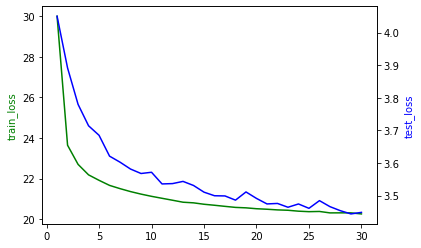

In [13]:
x = range(1,EPOCH+1)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x, train_losses, 'g-')
ax2.plot(x, test_losses, 'b-')
ax1.set_ylabel('train_loss', color='g')
ax2.set_ylabel('test_loss', color='b')
plt.show()
